# Задача

Этот набор данных содержит информацию о подержанных автомобилях.

- `Car_Name` - название автомобиля
- `Year` - год, в котором купил машину предыдущий владелец
- `Selling_Price` - цена продажи машины сейчас
- `Present_Price` - предыдущая цена покупки
- `Kms_Driven` - сколько километров проехала машина
- `Fuel_Type` - тип используемого топлива
- `Seller_Type` - тип продавца
- `Transmission` - тип коробки передач
- `Owner` - количество владельцев автомобиля до текущего хозяина

Целевой переменной считать `Selling_Price`.

1. После загрузки необходимо проанализировать существующие признаки.
2. Определите, какие признаки являются числовыми, а какие категориальными (кодом). Выведите список одних и других.
3. Используйте стратегию валидации Holdout. Постройте линейную регрессию на числовых признаках. Оцените качество работы с помощью метрик MSE и MAE.
4. Проанализируйте важность признаков без библиотеки yellowbrick.
5. Сравните результат вашего анализа с результатов yellowbrick.
6. Добавьте категориальные признаки при помощи метода sklearn.preprocessing.OneHotEncoder. [Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) + [Пример использования](https://www.dmitrymakarov.ru/data-analysis/encoding-10/#10-klass-onehotencoder)
7. Переобучите модель. Также проанализируйте важность признаков, что изменилось? А как изменились метрики?
8. Добавьте регуляризацию (3 типа). Как меняется важность признаков? Как изменяются метрики?
9. Добавьте [Learning Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) для одной из моделей. [Визуализируйте результат!](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py)

In [1]:
# необходимые библиотеки
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV, \
ShuffleSplit, learning_curve, LearningCurveDisplay
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import  mean_absolute_error, mean_squared_error
import numpy as np
from matplotlib import pyplot as plt
from yellowbrick.model_selection import FeatureImportances

In [2]:
sharing_url = "https://drive.google.com/file/d/1qeae-8oAfQnULTs838ROpupXLvMNwtiO/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df = pd.read_csv(download_url)

# Анализ существующих переменных

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


Можно увидеть, что значения переменных у нас находятся в разных порядках. Надо это запомнить, чтобы потом при необходимости нормализовать значения.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df['Owner'].unique()

array([0, 1, 3])

In [6]:
categor_variables = [str(i) for i in df.columns if df[i].dtype == 'object']
numerical_variables = [str(i) for i in df.columns if df[i].dtype != 'object']
print("The categorical variables in the dataframe are ",
      ', '.join(categor_variables), '.', sep='')
print("The numerical variables in the dataframe are ",
      ', '.join(numerical_variables), '.', sep='')

The categorical variables in the dataframe are Car_Name, Fuel_Type, Seller_Type, Transmission.
The numerical variables in the dataframe are Year, Selling_Price, Present_Price, Kms_Driven, Owner.


# Модель линейной регрессии: количественные признаки

## Предобработка данных

In [7]:
# проверка наличия пропущенных значений
df.isnull().values.any().any()

False

In [8]:
# векторизуем категориальные переменные (на всякий случай)
vectorizer = preprocessing.LabelEncoder()

for var in df.columns:
    if df[var].dtype == 'object':
        df[var] = vectorizer.fit_transform(df[var])

In [9]:
# разбиение на выборки
random_seed = 21
col_to_drop = categor_variables + ['Selling_Price']

X = df.drop(col_to_drop, axis=1)
y = df['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=random_seed)

In [10]:
X.head()

,Year,Present_Price,Kms_Driven,Owner
0,2014,5.59,27000,0
1,2013,9.54,43000,0
2,2017,9.85,6900,0
3,2011,4.15,5200,0
4,2014,6.87,42450,0


In [11]:
# нормализация
sc = MinMaxScaler()

pandas_columns = X_train.columns
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = pd.DataFrame(X_train, columns=pandas_columns)
X_test = pd.DataFrame(X_test, columns=pandas_columns)

## Валидация и обучение модели

In [12]:
# валидация Holdout

tuned_param = {'copy_X': [True, False], 'fit_intercept': [True, False],
               'n_jobs': [None, -1, 0, 1, 2, 3, 4],
               'positive': [True, False]}

# вот это делает сплит тренировочной выборки на тренировочную и валидационную
ps = ShuffleSplit()

clf = GridSearchCV(LinearRegression(),
                   param_grid=tuned_param,
                   n_jobs=2,
                   pre_dispatch="n_jobs",
                   cv=ps)
clf.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=2,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [None, -1, 0, 1, 2, 3, 4],
                         'positive': [True, False]},
             pre_dispatch='n_jobs')

In [13]:
# собственно, наши гиперпарметры
clf.get_params()

{'cv': ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
 'error_score': nan,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__positive': False,
 'estimator': LinearRegression(),
 'n_jobs': 2,
 'param_grid': {'copy_X': [True, False],
  'fit_intercept': [True, False],
  'n_jobs': [None, -1, 0, 1, 2, 3, 4],
  'positive': [True, False]},
 'pre_dispatch': 'n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [14]:
# обучение модели; так как все найденные параметры через Holdout совпадают
# с дефолтными значениями, то дополнительно мы ничего не меняем

model1 = LinearRegression()
model1.fit(X_train, y_train)

res_pred = X_test.copy()

res_pred['prediction'] = model1.predict(res_pred)
res_pred['real'] = y_test.values

In [15]:
# оценка качества работы модели
mae = mean_absolute_error(res_pred['real'], res_pred['prediction'])
mse = mean_squared_error(res_pred['real'], res_pred['prediction'])
print('The mean absolute error is ', mae)
print('The mean squared error is ', mse)

The mean absolute error is  1.0482669264406412
The mean squared error is  2.140078520254846


## Важность признаков без yellowbrick

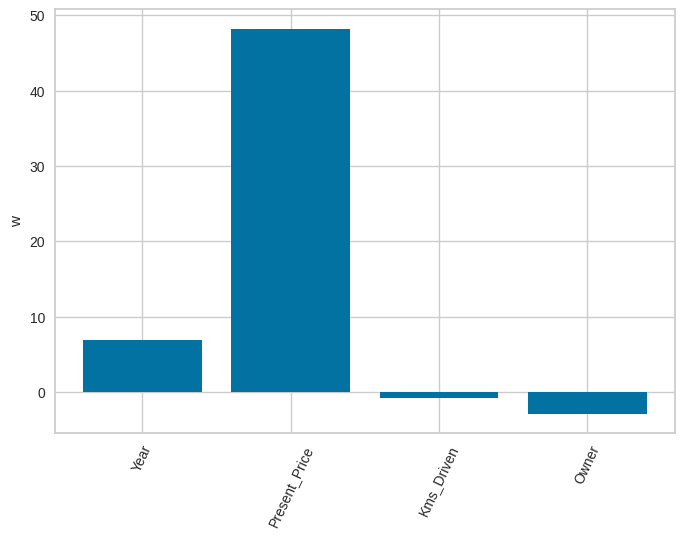

In [16]:
fig, subplot = plt.subplots()
plt.bar(np.arange(len(model1.coef_)), model1.coef_)
subplot.set_xticks(np.arange(len(model1.coef_)))
subplot.set_xticklabels(X.columns.tolist(), rotation=65)
subplot.set_ylabel('w')
fig.show()

Судя по графику, наиболее значимым признаком является текущая цена автомобиля.

## Важность признаков с yellowbrick

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


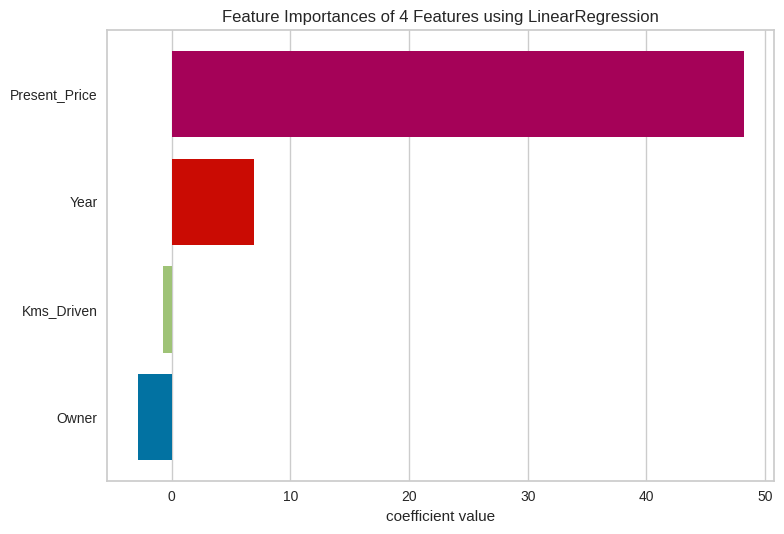

<Axes: title={'center': 'Feature Importances of 4 Features using LinearRegression'}, xlabel='coefficient value'>

In [17]:
viz = FeatureImportances(model1, relative=False)
viz.fit(X_train, y_train)
viz.show()

Как можно увидеть, то, как ранжированы признаки по важности, не поменялось по сравнению с тем, что мы анализировали без библиотеки yellowbrick.

# Модель линейной регрессии: количественные и категориальные признаки

## Добавление категориальных признаков

In [18]:
# One-hot Encoder
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categor_variables])

one_hot_df = pd.DataFrame(one_hot_encoded,
                          columns=encoder.get_feature_names_out(categor_variables))

In [19]:
one_hot_df['Selling_Price'] = df['Selling_Price']

## Переобучение модели

### Переобучение модели только с категориальными переменными

#### Валидация и обучение модели. 1 версия

In [20]:
# разбиение на выборки
X_cat = one_hot_df.drop('Selling_Price', axis=1)
y_cat = one_hot_df['Selling_Price']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat,
                                                                    test_size=0.1,
                                                                    random_state=random_seed)

In [21]:
# валидация Holdout
clf_cat = GridSearchCV(LinearRegression(),
                   param_grid=tuned_param,
                   n_jobs=2,
                   pre_dispatch="n_jobs",
                   cv=ps)
clf_cat.fit(X_train_cat, y_train_cat)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=2,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [None, -1, 0, 1, 2, 3, 4],
                         'positive': [True, False]},
             pre_dispatch='n_jobs')

In [22]:
clf_cat.get_params()

{'cv': ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
 'error_score': nan,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__positive': False,
 'estimator': LinearRegression(),
 'n_jobs': 2,
 'param_grid': {'copy_X': [True, False],
  'fit_intercept': [True, False],
  'n_jobs': [None, -1, 0, 1, 2, 3, 4],
  'positive': [True, False]},
 'pre_dispatch': 'n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [23]:
model_cat = LinearRegression()
model_cat.fit(X_train_cat, y_train_cat)

res_pred_cat = X_test_cat.copy()

res_pred_cat['prediction'] = model_cat.predict(res_pred_cat)
res_pred_cat['real'] = y_test_cat.values

In [24]:
df['Car_Name'].unique()

array([90, 93, 68, 96, 92, 95, 91, 62, 76, 73, 63, 85,  0, 65, 89, 81, 86,
       71, 77, 78, 80, 70, 79, 67, 88, 49, 56, 42, 11, 46, 43, 40, 48, 41,
       44, 17, 45, 47,  6,  4, 32, 60, 58, 51, 14, 37, 20,  7,  5, 57, 12,
       15, 52, 26, 16, 61, 31, 54, 38,  8, 28,  1, 25, 34, 59, 13,  2, 35,
       22, 39, 30, 53, 23, 27, 33,  9, 50, 55, 36, 21, 29, 10, 24, 19, 18,
        3, 84, 82, 83, 75, 97, 74, 72, 94, 69, 66, 64, 87])

#### Важность признаков. 1 версия

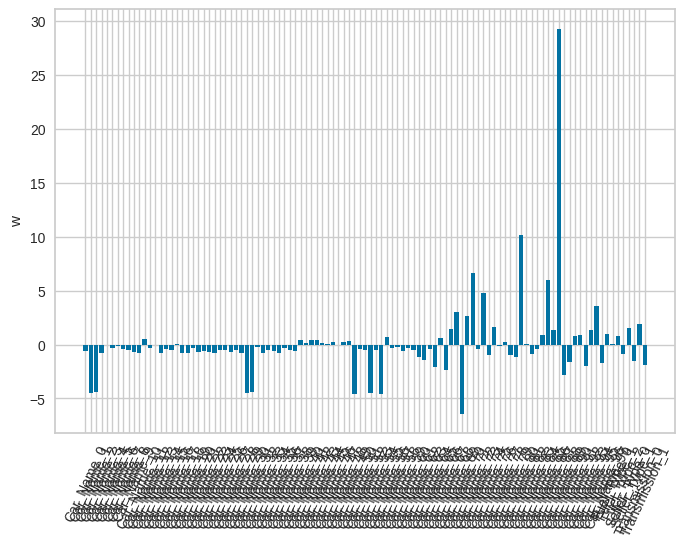

In [25]:
fig, subplot = plt.subplots()
plt.bar(np.arange(len(model_cat.coef_)), model_cat.coef_)
subplot.set_xticks(np.arange(len(model_cat.coef_)))
subplot.set_xticklabels(X_cat.columns.tolist(), rotation=65)
subplot.set_ylabel('w')
fig.show()

Получилось так себе. Проверим, сколько у нас существует уникальных значений по каждому признаку.

In [26]:
for col in categor_variables:
    print(col, ': ', df[col].unique().shape, sep='')

Car_Name: (98,)
Fuel_Type: (3,)
Seller_Type: (2,)
Transmission: (2,)


Кажется, что Car_Name стоит убрать как предиктор, поскольку эта категориальная переменная принимает слишком много значений. Попробуем еще раз без нее.

#### Валидация и обучение модели. 2 версия

In [27]:
# One-hot Encoder

categor_variables_wcn = [var for var in categor_variables if var != 'Car_Name']

one_hot_encoded = encoder.fit_transform(df[categor_variables_wcn])

one_hot_df_2 = pd.DataFrame(one_hot_encoded,
                          columns=encoder.get_feature_names_out(categor_variables_wcn))

one_hot_df_2['Selling_Price'] = df['Selling_Price']

In [28]:
random_seed = 21

X_cat_2 = one_hot_df_2.drop(['Selling_Price'], axis=1)
y_cat_2 = one_hot_df_2['Selling_Price']

X_train_cat_2, X_test_cat_2, y_train_cat_2, y_test_cat_2 = train_test_split(X_cat_2, y_cat_2,
                                                                    test_size=0.1,
                                                                    random_state=random_seed)

In [29]:
# валидация Holdout

clf_cat_2 = GridSearchCV(LinearRegression(),
                   param_grid=tuned_param,
                   n_jobs=2,
                   pre_dispatch="n_jobs",
                   cv=ps)
clf_cat_2.fit(X_train_cat_2, y_train_cat_2)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
28 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_base.py", line 640, in fit
    self.coef_ = optimize.nnls

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=2,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [None, -1, 0, 1, 2, 3, 4],
                         'positive': [True, False]},
             pre_dispatch='n_jobs')

In [30]:
clf_cat_2.get_params()

{'cv': ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
 'error_score': nan,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__positive': False,
 'estimator': LinearRegression(),
 'n_jobs': 2,
 'param_grid': {'copy_X': [True, False],
  'fit_intercept': [True, False],
  'n_jobs': [None, -1, 0, 1, 2, 3, 4],
  'positive': [True, False]},
 'pre_dispatch': 'n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [31]:
model_cat_2 = LinearRegression()
model_cat_2.fit(X_train_cat_2, y_train_cat_2)

res_pred_cat_2 = X_test_cat_2.copy()

res_pred_cat_2['prediction'] = model_cat_2.predict(res_pred_cat_2)
res_pred_cat_2['real'] = y_test_cat_2.values

#### Важность признаков. 2 версия

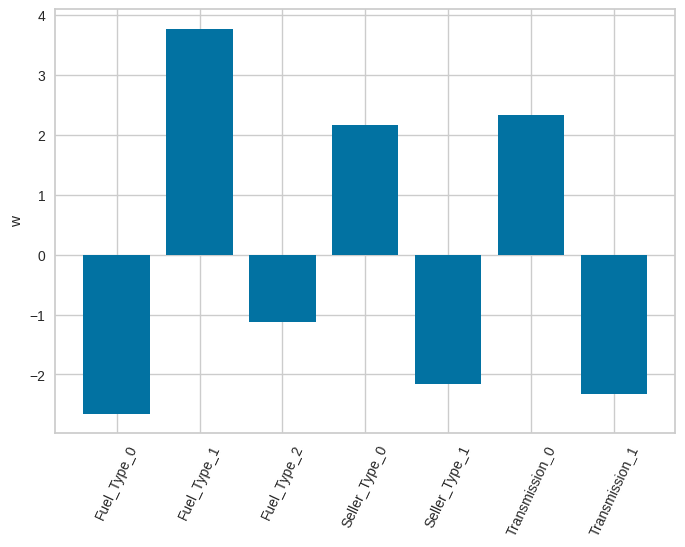

In [32]:
# без yellowbrick
fig, subplot = plt.subplots()
plt.bar(np.arange(len(model_cat_2.coef_)), model_cat_2.coef_)
subplot.set_xticks(np.arange(len(model_cat_2.coef_)))
subplot.set_xticklabels(X_cat_2.columns.tolist(), rotation=65)
subplot.set_ylabel('w')
fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


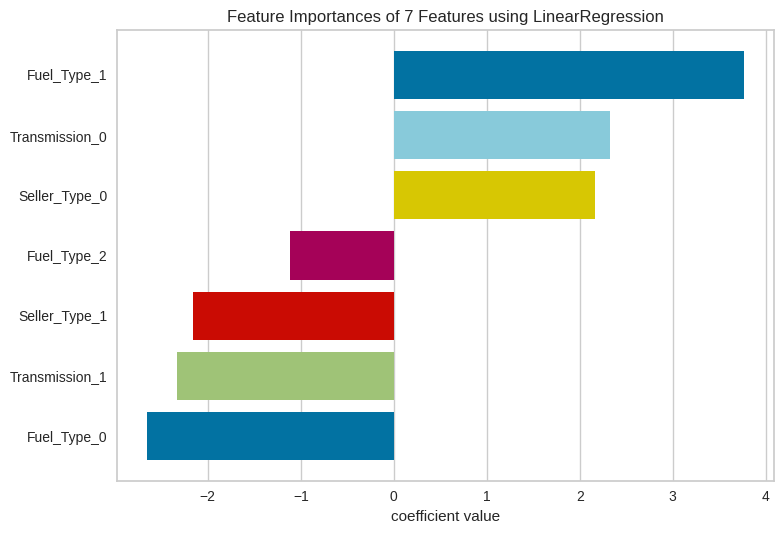

<Axes: title={'center': 'Feature Importances of 7 Features using LinearRegression'}, xlabel='coefficient value'>

In [33]:
# с yellowbrick

viz = FeatureImportances(model_cat_2, relative=False)
viz.fit(X_train_cat_2, y_train_cat_2)
viz.show()

Сразу отметим интересный момент: штука получилась зеркальной. Я бы сказала, что Fuel_Type в любом случае оказывается более значимым фактором для модели, чем Seller_Type/Transmission.

Ну и напоследок посмотрим на качество.

In [34]:
# оценка качества работы модели

mae = mean_absolute_error(res_pred_cat_2['real'], res_pred_cat_2['prediction'])
mse = mean_squared_error(res_pred_cat_2['real'], res_pred_cat_2['prediction'])
print('The mean absolute error is ', mae)
print('The mean squared error is ', mse)

The mean absolute error is  2.3907241610691012
The mean squared error is  9.336259231413422


Такое: наша ошибка выросла. Возможно, если мы обучим модель, где используем в качестве предикторов и количественные признаки, получится лучше.

### Переобучение модели с категориальными и числовыми переменными

#### Предобрработка и разделение на выборки

In [35]:
# сделаем датафрейм с необходимыми нам переменными

df_cat_num = pd.concat([X, one_hot_df_2], axis=1)
df_cat_num.head()

,Year,Present_Price,Kms_Driven,Owner,Fuel_Type_0,Fuel_Type_1,Fuel_Type_2,Seller_Type_0,Seller_Type_1,Transmission_0,Transmission_1,Selling_Price
0,2014,5.59,27000,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.35
1,2013,9.54,43000,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.75
2,2017,9.85,6900,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,7.25
3,2011,4.15,5200,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.85
4,2014,6.87,42450,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.60


In [36]:
# разбиение на выборки

X_cat_num = df_cat_num.drop('Selling_Price', axis=1)
y_cat_num = df_cat_num['Selling_Price']

X_train_cat_num, X_test_cat_num, y_train_cat_num, y_test_cat_num = train_test_split(X_cat_num,
                                                                                    y_cat_num,
                                                                    test_size=0.1,
                                                                    random_state=random_seed)

In [37]:
# нормализация

pandas_columns = X_train_cat_num.columns
X_train_cat_num = sc.fit_transform(X_train_cat_num)
X_test_cat_num = sc.transform(X_test_cat_num)

X_train_cat_num = pd.DataFrame(X_train_cat_num, columns=pandas_columns)
X_test_cat_num = pd.DataFrame(X_test_cat_num, columns=pandas_columns)

#### Валидация и обучение

In [38]:
# валидация

clf_cm = GridSearchCV(LinearRegression(),
                   param_grid=tuned_param,
                   n_jobs=2,
                   pre_dispatch="n_jobs",
                   cv=ps)
clf_cm.fit(X_train_cat_num, y_train_cat_num)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
14 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_base.py", line 640, in fit
    self.coef_ = optimize.nnls

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=2,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [None, -1, 0, 1, 2, 3, 4],
                         'positive': [True, False]},
             pre_dispatch='n_jobs')

In [39]:
clf_cm.get_params()

{'cv': ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
 'error_score': nan,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__positive': False,
 'estimator': LinearRegression(),
 'n_jobs': 2,
 'param_grid': {'copy_X': [True, False],
  'fit_intercept': [True, False],
  'n_jobs': [None, -1, 0, 1, 2, 3, 4],
  'positive': [True, False]},
 'pre_dispatch': 'n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [40]:
model_cm = LinearRegression()
model_cm.fit(X_train_cat_num, y_train_cat_num)

res_pred_cm = X_test_cat_num.copy()

res_pred_cm['prediction'] = model_cm.predict(res_pred_cm)
res_pred_cm['real'] = y_test_cat_num.values

In [41]:
# оценка качества работы модели
mae = mean_absolute_error(res_pred_cm['real'], res_pred_cm['prediction'])
mse = mean_squared_error(res_pred_cm['real'], res_pred_cm['prediction'])
print('The mean absolute error is ', mae)
print('The mean squared error is ', mse)

The mean absolute error is  1.1573076704178697
The mean squared error is  2.1948540862022905


Ошибка стала меньше, чем была в случае модели исключительно с категориальными переменными, но она все еще больше, чем в случае только с числовыми переменными, причем статистически значимо (тест Спирмена показал pvalue=4.9840004712958914e-15).

In [42]:
from scipy.stats import wilcoxon, spearmanr

# проверяем нормальность распределений, чтобы понять, можем ли мы применить тест
# Спирмена
print('Wilcoxon test for numerical-only predictions:', wilcoxon(res_pred['prediction']).pvalue, '\n',
      'Wilcoxon test for numerical-catrgorical predictions:', wilcoxon(res_pred_cm['prediction']).pvalue)
print('____')
# проводим тест спирмена
print(spearmanr(res_pred_cm['prediction'], res_pred['prediction']))

Wilcoxon test for numerical-only predictions: 1.30385160446167e-08 
 Wilcoxon test for numerical-catrgorical predictions: 2.859160304069519e-07
____
SignificanceResult(statistic=0.9395161290322583, pvalue=4.9840004712958914e-15)


#### Важность признаков

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


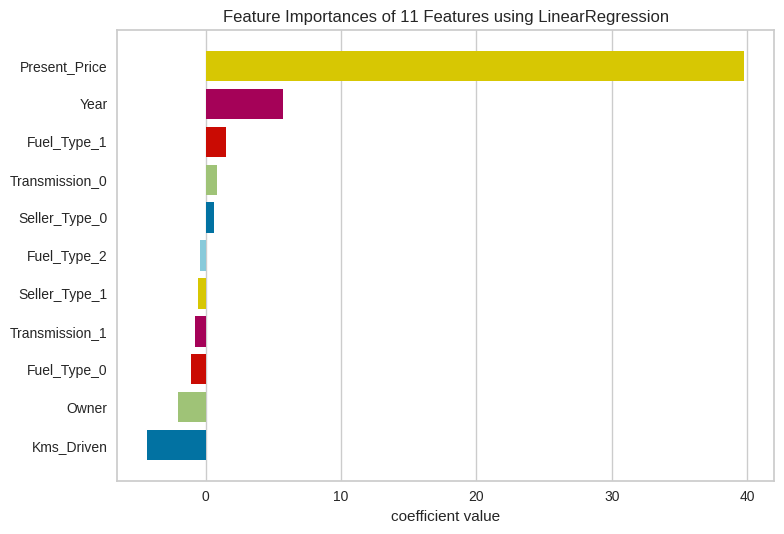

<Axes: title={'center': 'Feature Importances of 11 Features using LinearRegression'}, xlabel='coefficient value'>

In [43]:
viz = FeatureImportances(model_cm, relative=False)
viz.fit(X_train_cat_num, y_train_cat_num)
viz.show()

После переобучения модели самым важным признаком для предсказания цены все еще остается Present_Price. Также можно заметить, что категориальные переменные имеют м**е**ньшую значимость, чем числовые.

# Регуляризация

Регуляризацию будем использовать с моделью, где представлены и категориальные, и числовые признаки.

## L1: Lasso

In [44]:
# обучение модели
model_lasso = Lasso()
model_lasso.fit(X_train_cat_num, y_train_cat_num)

Lasso()

In [45]:
# результаты модели
res_pred_cm_lasso = X_test_cat_num.copy()

res_pred_cm_lasso['prediction'] = model_lasso.predict(res_pred_cm_lasso)
res_pred_cm_lasso['real'] = y_test_cat_num.values


mae = mean_absolute_error(res_pred_cm_lasso['real'],
                          res_pred_cm_lasso['prediction'])
mse = mean_squared_error(res_pred_cm_lasso['real'],
                         res_pred_cm_lasso['prediction'])
print('The mean absolute error is ', mae)
print('The mean squared error is ', mse)

The mean absolute error is  2.8550753188880833
The mean squared error is  15.837333686223255


Ошибка выросла, печально :(

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


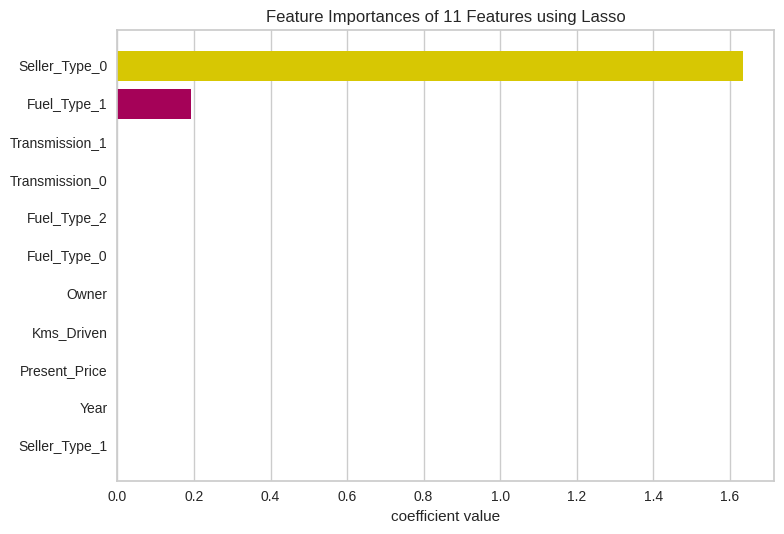

<Axes: title={'center': 'Feature Importances of 11 Features using Lasso'}, xlabel='coefficient value'>

In [46]:
# важность признаков

viz = FeatureImportances(model_lasso, relative=False)
viz.fit(X_train_cat_num, y_train_cat_num)
viz.show()

## L2: Ridge

In [47]:
model_ridge = Ridge()
model_ridge.fit(X_train_cat_num, y_train_cat_num)

Ridge()

In [48]:
# результаты модели
res_pred_cm_ridge = X_test_cat_num.copy()

res_pred_cm_ridge['prediction'] = model_ridge.predict(res_pred_cm_ridge)
res_pred_cm_ridge['real'] = y_test_cat_num.values


mae = mean_absolute_error(res_pred_cm_ridge['real'],
                          res_pred_cm_ridge['prediction'])
mse = mean_squared_error(res_pred_cm_ridge['real'],
                         res_pred_cm_ridge['prediction'])
print('The mean absolute error is ', mae)
print('The mean squared error is ', mse)

The mean absolute error is  1.5340140302236671
The mean squared error is  3.7488130343739283


С L2 ошибка уже гораздо меньше, что радует.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


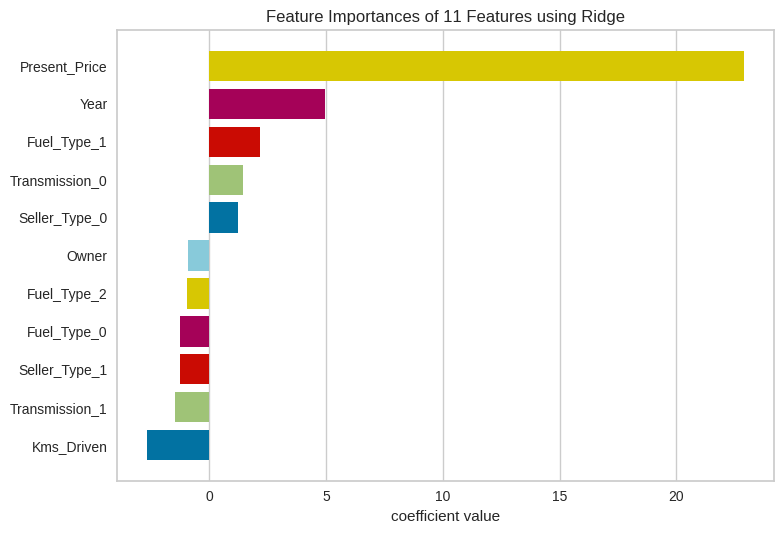

<Axes: title={'center': 'Feature Importances of 11 Features using Ridge'}, xlabel='coefficient value'>

In [49]:
# важность признаков

viz = FeatureImportances(model_ridge, relative=False)
viz.fit(X_train_cat_num, y_train_cat_num)
viz.show()

## L3: ElasticNet

In [50]:
model_elastic = ElasticNet()
model_elastic.fit(X_train_cat_num, y_train_cat_num)

ElasticNet()

In [51]:
# результаты модели
res_pred_cm_elastic = X_test_cat_num.copy()

res_pred_cm_elastic['prediction'] = model_elastic.predict(res_pred_cm_elastic)
res_pred_cm_elastic['real'] = y_test_cat_num.values


mae = mean_absolute_error(res_pred_cm_elastic['real'],
                          res_pred_cm_elastic['prediction'])
mse = mean_squared_error(res_pred_cm_elastic['real'],
                         res_pred_cm_elastic['prediction'])
print('The mean absolute error is ', mae)
print('The mean squared error is ', mse)

The mean absolute error is  2.778822483504365
The mean squared error is  13.949458504327348


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


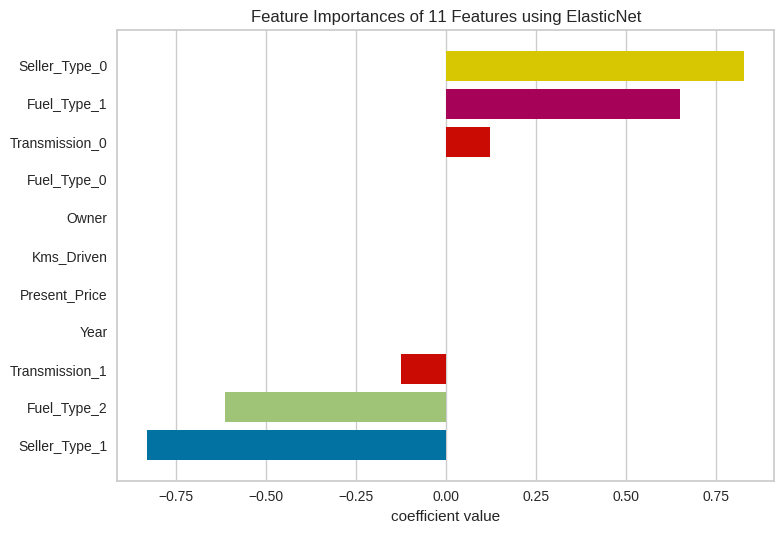

<Axes: title={'center': 'Feature Importances of 11 Features using ElasticNet'}, xlabel='coefficient value'>

In [52]:
# важность признаков

viz = FeatureImportances(model_elastic, relative=False)
viz.fit(X_train_cat_num, y_train_cat_num)
viz.show()

При L2-регуляризации, как можно увидеть на графиках, учитывается больше признаков, чем при L1 и L3, одновременно с этим сохранено доминирование Present_Price. При этом ошибка для L2 составляет наименьшие значения из всех трех моделей. Можно сделать два предположения:
* ключевым оказался предиктор Present_Price, и если модель отметила его как наиболее важный, то ошибка будет меньше
* (вряд ли) важно учитывать каждый из предикторов для лучшего качества работы алгоритма

# Learning Curve для Ridge-модели

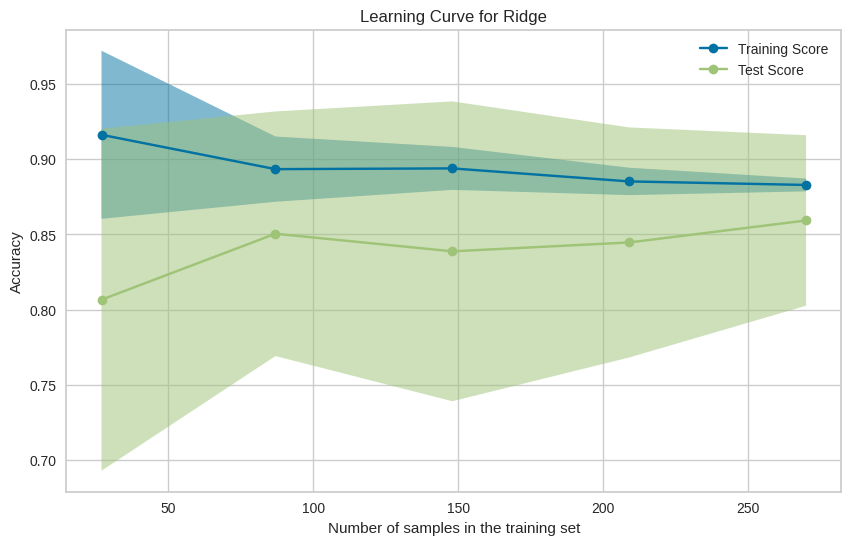

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_cat_num,
    "y": y_cat_num,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(model_ridge, **common_params, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {model_ridge.__class__.__name__}")

plt.show()